# Geospatial analysis of the determinants of cancer screening participation

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
os.environ['USE_PYGEOS'] = '0'
import glob
import random
import sys
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
# import folium
import libpysal as lps
import seaborn as sns
import mapclassify as mc
import esda
from difflib import SequenceMatcher
from pathlib import Path
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import abline_plot

import six
import uuid
import pickle
from sqlalchemy import create_engine

engine = create_engine('postgresql://postgres@localhost:5432/david')
from utils import *
from matplotlib import colors
from matplotlib.collections import LineCollection
from shapely.geometry import Point, Polygon

pd.set_option('display.max_columns', 500)

sys.path.append('/Users/david/Dropbox/PhD/Scripts/Spatial analyses')
import pyspace

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/david/miniforge3/envs/gira

# Data preparation

## Import data

In [3]:
#Set working directory
mydir = Path(os.getcwd())
data_folder = mydir / '../Data' #Set data folder

In [4]:
file = data_folder / "extractionGE_v3.csv" #Data source file containing the screening data
df = pd.read_csv(file,sep = ";",low_memory = False) #Load data

In [5]:
len(df.numeroDossier.unique())

136529

In [6]:
df['dateInvitation'] = pd.to_datetime(df['dateInvitation'])
df['dateMammographie'] = pd.to_datetime(df['dateMammographie'])

df['year_invit'] = df.dateInvitation.dt.year
df['year_mammo'] = df.dateMammographie.dt.year

In [7]:
df = df.assign(mammo = 1* (df.dateMammographie.isnull()==False))

In [8]:
df_2020 = df[df.year_invit == 2020]

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

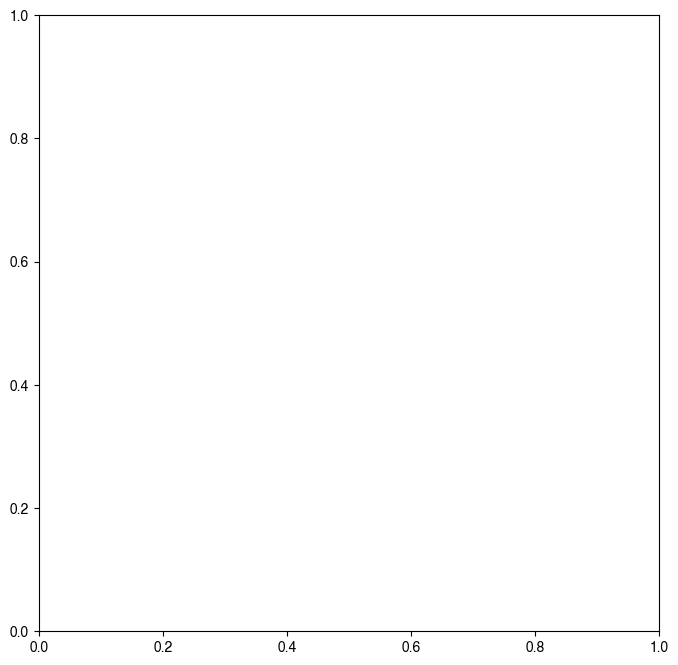

In [27]:
n_mammo_by_year = pd.DataFrame(df.groupby('year_mammo').mammo.sum()).reset_index()
pal = sns.color_palette("Blues", len(n_mammo_by_year))
rank = n_mammo_by_year['mammo'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
chart = sns.barplot(x="year_mammo", y="mammo", data=n_mammo_by_year, palette = np.array(pal)[rank], ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel("Année",size = 14)
chart.set_ylabel('Nombre de mammographies',size = 14)
show_values(chart, digits = 0, fontsize = 7)
plt.savefig('../Results/N mammographies par année - Données brutes.png', dpi = 300)

In [11]:
age_cats = df.groupby('GroupeAge').size()
age_cats =  pd.DataFrame(age_cats).reset_index()
age_cats.columns = ["Groupe d'âge","Nombre d'invitations (N)"]

<Axes: >

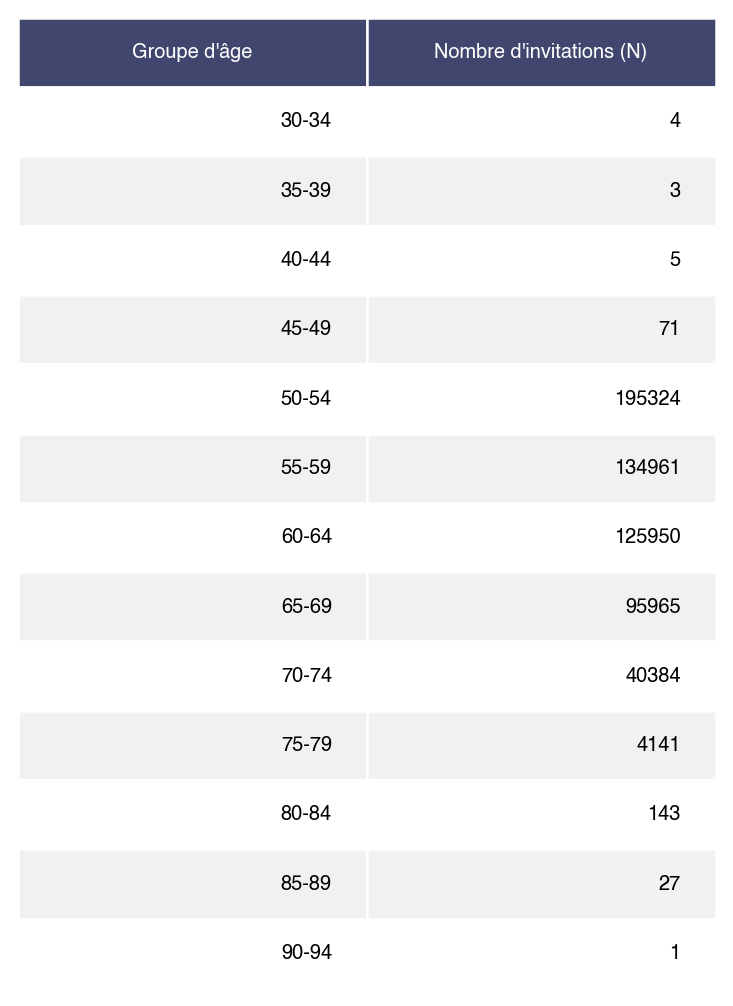

In [12]:
render_mpl_table(age_cats, header_columns=0, col_width=2.5, font_size = 8)

In [13]:
age_cats[age_cats["Groupe d'âge"].isin(['50-54','55-59','60-64','65-69','70-74']) == False].sum()

Groupe d'âge                30-3435-3940-4445-4975-7980-8485-8990-94
Nombre d'invitations (N)                                        4395
dtype: object

### Doublons

In [14]:
df[df[['year_invit','numeroDossier','numeroInvitation']].duplicated()]

,numeroDossier,numeroInvitation,GroupeAge,numeroDepistage,adresse1,adresse2,adresse3,localité,NPA,etatCivil,profession,medecin,autreMedecin,dateInvitation,dateRappel,dateMammographie,mammoAnterieure,ATF,conclusion,centre,year_invit,year_mammo,mammo
70395,8009247415,2,65-69,2,"2, CH.DU PETIT-MONTFLEURY",NaN,NaN,Versoix,1290,Divorcé,912 - EDUCATRICE,non,non,2002-01-24,NaN,NaT,NaN,NaN,NaN,NaN,2002,NaN,0
154723,7008958329,3,55-59,2,RUE DU GRAND-PRÉ 2,NaN,NaN,Genève,1202,Marié,951 - SANS ACTIVITE,non,non,2005-10-01,NaN,NaT,oui,je ne sais pas,NaN,NaN,2005,NaN,0
249893,2008871697,5,70-74,3,"4, RUE GUYE",NaN,NaN,Genève,1203,Veuve,951 - SANS ACTIVITE,non,non,2009-06-30,NaN,NaT,NaN,NaN,NaN,NaN,2009,NaN,0
254191,5008671926,3,55-59,2,RUE DES VIEUX-GRENADIERS 4,,NaN,Genève,1205,Marié,672 - VENDEUSE,non,non,2009-09-28,2009-09-28,NaT,NaN,NaN,NaN,NaN,2009,NaN,0
254755,4009252869,6,70-74,2,"6, RUE DE HESSE",NaN,NaN,Genève,1204,Divorcé,674 - LIBRAIRIE,non,non,2009-10-06,NaN,NaT,NaN,NaN,NaN,NaN,2009,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590944,1008226290,4,55-59,1,RUE LE-CORBUSIER 28,NaN,NaN,Genève,1208,Marié,692 - ASSISTANTE EN MARKETING,oui,non,2021-01-22,2021-04-30,2022-01-18,oui,oui,Négative,ImageRive,2021,2022.0,1
592939,3017668934,2,55-59,2,C/O MME AMOUZEGAR ARIANNA,PLATEAU DE FRONTENEX 9 C,NaN,Cologny,1223,Célibataire,767 - EMPLOYEE DE MAISON (S.A.I.),oui,non,2021-01-22,NaN,2021-03-16,non,oui,Négative,Centre d'imagerie Rive Droite SA,2021,2021.0,1
594158,6008410125,6,60-64,3,RUE DES ÉVAUX 1,NaN,NaN,Onex,1213,Marié,487 - OUVRIERE,oui,oui,2021-01-22,2021-04-30,2021-11-24,oui,non,Négative,CIO,2021,2021.0,1
594177,4008738694,11,65-69,8,RUE MICHEL-SIMON 9,NaN,NaN,Genève,1205,Divorcé,756 - AIDE DE RESTAURANT,oui,non,2021-01-22,NaN,2021-11-26,oui,non,Négative,CIO,2021,2021.0,1


### Distribution par année

In [15]:
_ = pd.DataFrame(df.groupby('year_invit').size()).reset_index()
_.columns = ["Année d'invitation","Nombre d'invitations (N)"]

<Axes: >

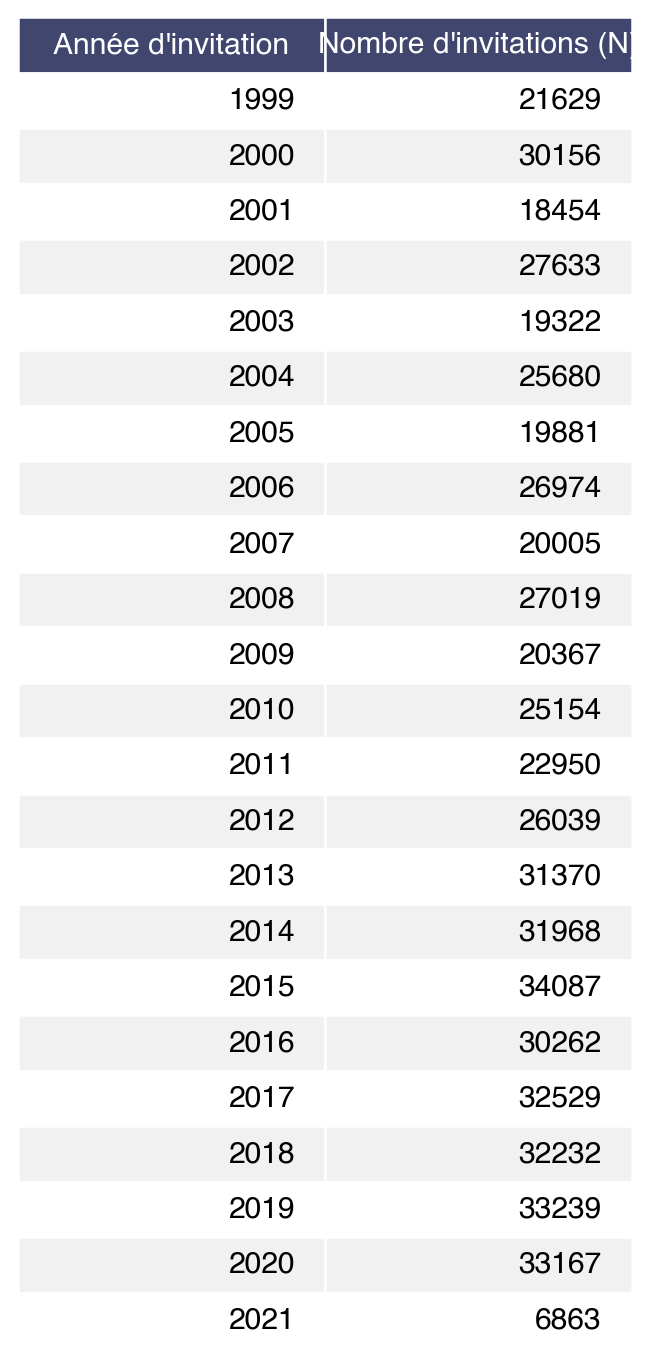

In [16]:
render_mpl_table(_, header_columns=0, col_width=2.2, row_height = 0.4, font_size = 12)

## Data cleaning

In [17]:
#Set all column names to lowercase
df.columns = map(str.lower, df.columns)

In [18]:
#eliminate noisy information from addresses
df.loc[df.adresse1.str.contains('C/O')==True, 'adresse1'] = '' 
df.loc[df.adresse1.str.contains('CASE POSTALE')==True, 'adresse1'] = ''
df.loc[df.adresse2.str.contains('CASE POSTALE')==True, 'adresse2'] = ''
df.loc[df.adresse2.isnull()==True, 'adresse2'] = ''

In [19]:
#Create new column containing country information
df['country'] = 'Suisse'
df.loc[df.npa.str.contains('F-|FR-')==True, 'country'] = 'France'
df.loc[df.localité.str.contains('FRANCE')==True, 'country'] = 'France'

In [20]:
#Repare npa field
df['npa'] = df['npa'].str.replace('F-','').str.replace('FR -','').str.replace('F -','').str.replace('F','').str.replace('-','').str.strip().replace('',np.nan)
df['npa'] = df.npa.fillna(-1).astype(float).astype(int)
df['npa'] = df['npa'].astype(str).replace('-1',np.nan)

In [21]:
#Create new column : street
df['street'] = df['adresse1'] +' '+ df['adresse2']
df['street'] = df['street'].replace(',','', regex = True)

In [22]:
df = df.rename(columns = {'npa':'zipcode','localité':'city'})
df['canton'] = 'ge'
df.to_feather(data_folder/'first_cleanup_giracs.feather')

In [23]:
_regbl_data_folder = Path("/Users/david/Dropbox/PhD/GitHub/Swiss-Geocoder/").resolve()
regbl_address = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_address_2022.feather')
regbl_street = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_street_2022.feather')

In [24]:
#Make street column format consistent
##Handling streets starting with the street number (i.e. 26, Rue de la route)
# df.loc[df.street.str.split(',').str[0].str.isdigit()==True, 'street'] = df[df.street.str.split(',').str[0].str.isdigit()==True].street.str.split(',').str[::-1].str.join(' ')
#A tad awful...handling street numbers containing letters
#This single line...updates the fields having a street number that contains a letter (i.e. 43 A) and rebuilds the street such as it becomes (43A)
# df.loc[(df.street.str[-1].str.isdigit()==False)&(df.street.str.split(' ').str[-2].str.isdigit()==True),'street'] = df[(df.street.str[-1].str.isdigit()==False)&(df.street.str.split(' ').str[-2].str.isdigit()==True)].street.str.split(' ').str[:-2].str.join(' ')+' '+df[(df.street.str[-1].str.isdigit()==False)&(df.street.str.split(' ').str[-2].str.isdigit()==True)].street.str.split(' ').str[-2:].str.join('')

# df['street'] = df.street.str.strip().str.lower()

# df.loc[df['street'].str.strip() == '', 'street'] = np.nan

In [25]:
# #Create column containing street number
# df['adr_num'] = df[df.street.isnull()==False].apply(lambda x:get_adr_num(x.street),axis = 1)
# df['adr_num'] = df['adr_num'].fillna(np.nan)
# df.loc[df['adr_num'] == 'nan', 'adr_num'] = np.nan

In [26]:
# df['streetname'] = df[df.adr_num.isnull()==False].apply(lambda x: x.street.replace(x.adr_num,'').lower().rstrip(), axis = 1)

### Geocoded dataset

In [27]:
df_geocoded = pd.read_excel(data_folder/'Processed data'/'geosoc_geocoded_80.xlsx')

In [28]:
lake = gpd.read_file('/Users/david/Dropbox/PhD/GitHub/COVID19/Data/Mapping/lake.geojson')
cantons = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
communes = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp')
communes = communes[communes.KANTONSNUM == 25]
cantons = cantons.to_crs(2056)
communes = communes.to_crs(2056)

In [29]:
df_geocoded = df_geocoded.drop(['Unnamed: 0'], axis = 1)

In [30]:
df_geocoded = df_geocoded[~df_geocoded[['numerodossier','numeroinvitation']].duplicated()]

In [31]:
#Create geodataframe
gdf_geocoded = pyspace.make_gdf(df_geocoded,2056,'E','N')
gdf_geom_uniq = gdf_geocoded.drop_duplicates(subset = ['address_id','full_address'])
gdf_geocoded_ok = gdf_geocoded[gdf_geocoded.comment.str.contains('Ok')]

def get_n_neighbors(df,w):
    """
    Returns a new column containing the number of 
    neighbors in certain radius (defined by the used weights)
    """
    for key,neighbors in w:
        df.at[key, 'neighbors'] = len(neighbors)
        
gdf_geom_uniq = pyspace.make_gdf(gdf_geom_uniq,2056,'E','N')
gdf_geom_uniq = gpd.sjoin(gdf_geom_uniq,communes[['NAME','geometry']], predicate = 'intersects').drop('index_right',axis =1)
#Print the number of different geometries after small alteration to addresses

In [32]:
gdf_geocoded.groupby('comment').size()

comment
Low quality                     1609
Low quality - Street level       209
No match                          64
Not in CH                        324
Ok                            594101
Ok - Street level                413
dtype: int64

## Quick quality control

In [33]:
def show_values(axs, orient="v",digits = 2, fontsize = 8, space=.05):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.02)
                value = '{:.{}f}'.format(p.get_height(), digits)
                ax.text(_x, _y, value,size = fontsize, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.{}f}'.format(p.get_width(), digits)
                ax.text(_x, _y, value,size = fontsize, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax, digits)
    else:
        _single(axs)

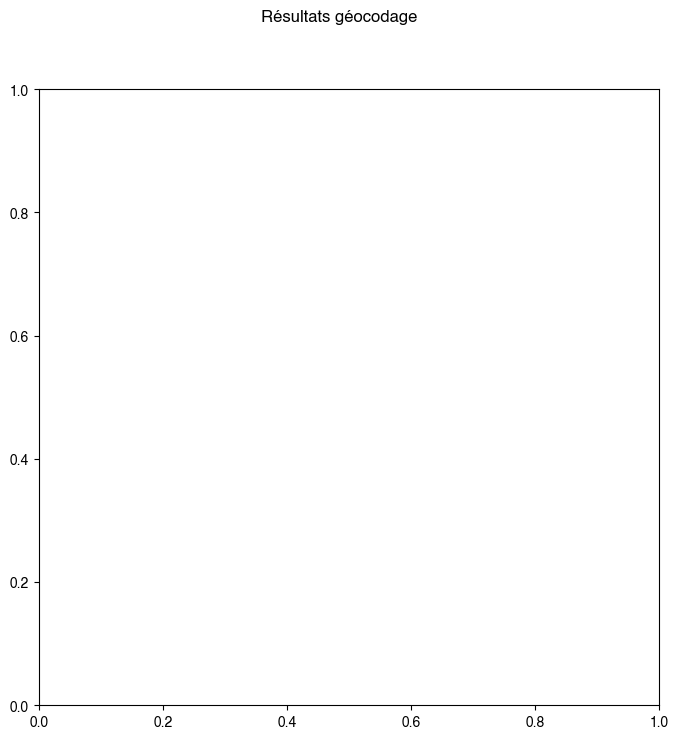

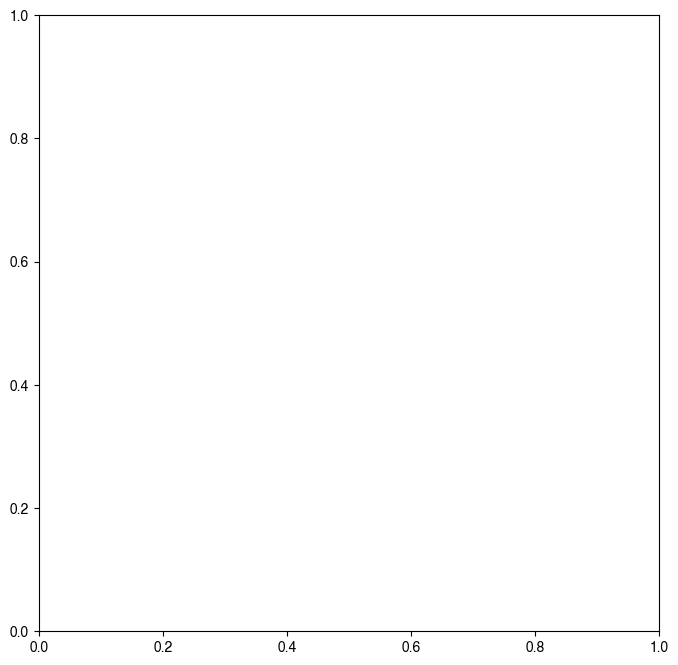

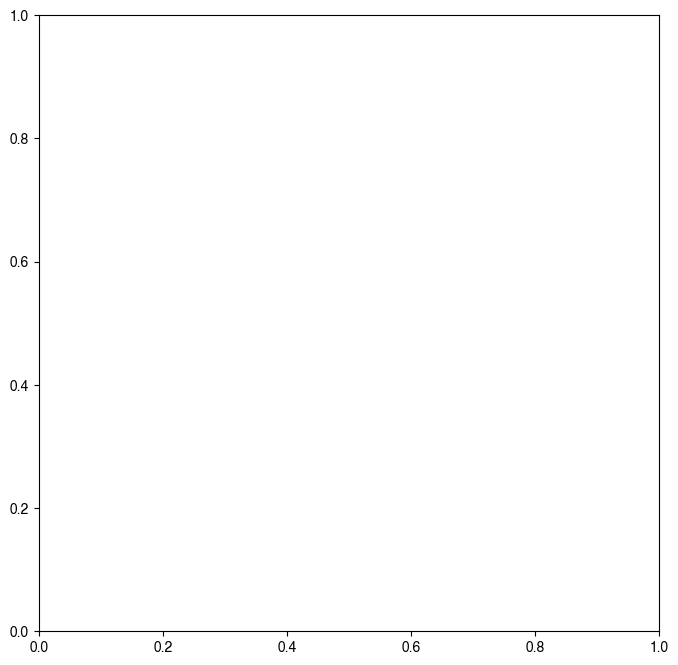

In [34]:
# sns.set_theme(style="white")
# sns.set_context("paper")

# fig, ax = plt.subplots(figsize = (8,8))
fig, axes = plt.subplots(figsize=(8, 8), sharey=False)
fig.suptitle('Résultats géocodage')
geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts()).reset_index()
geocoding_res['count'] = geocoding_res['count'].astype(int)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('Classes de géocodage',size = 14)
chart.set_ylabel('Nombre',size = 14)
fig, axes = plt.subplots(figsize=(8, 8), sharey=False)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = ax)
chart.set_yscale("log")
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('Classes de géocodage',size = 14)
chart.set_ylabel('Nombre',size = 14)
show_values(chart, digits = 1)
fig, axes = plt.subplots(figsize=(8, 8), sharey=False)

geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts(normalize = True).mul(100)).reset_index()
chart = sns.barplot(x="comment", y="proportion", data=geocoding_res, ax = ax)
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('Classes de géocodage',size = 14)
chart.set_ylabel('Nombre',size = 14)
show_values(chart, digits = 1)

Text(0, 0.5, 'Frequency (log)')

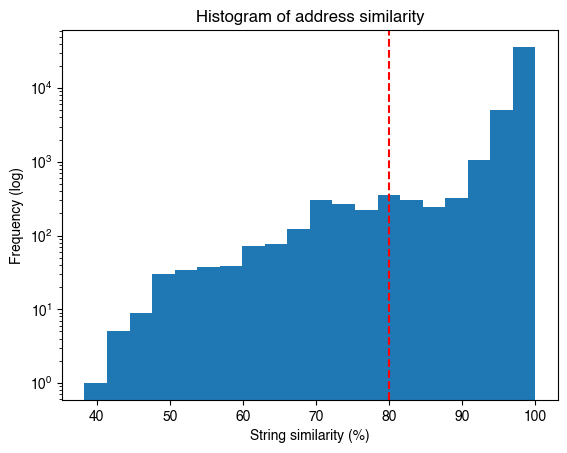

In [35]:
plt.plot()
gdf_geom_uniq[gdf_geom_uniq.similarity.isnull()==False].similarity.plot.hist(bins = 20,log = True)
plt.axvline(x=80,color = 'red',linestyle='--')
plt.title('Histogram of address similarity')
plt.xlabel('String similarity (%)')
plt.ylabel('Frequency (log)')

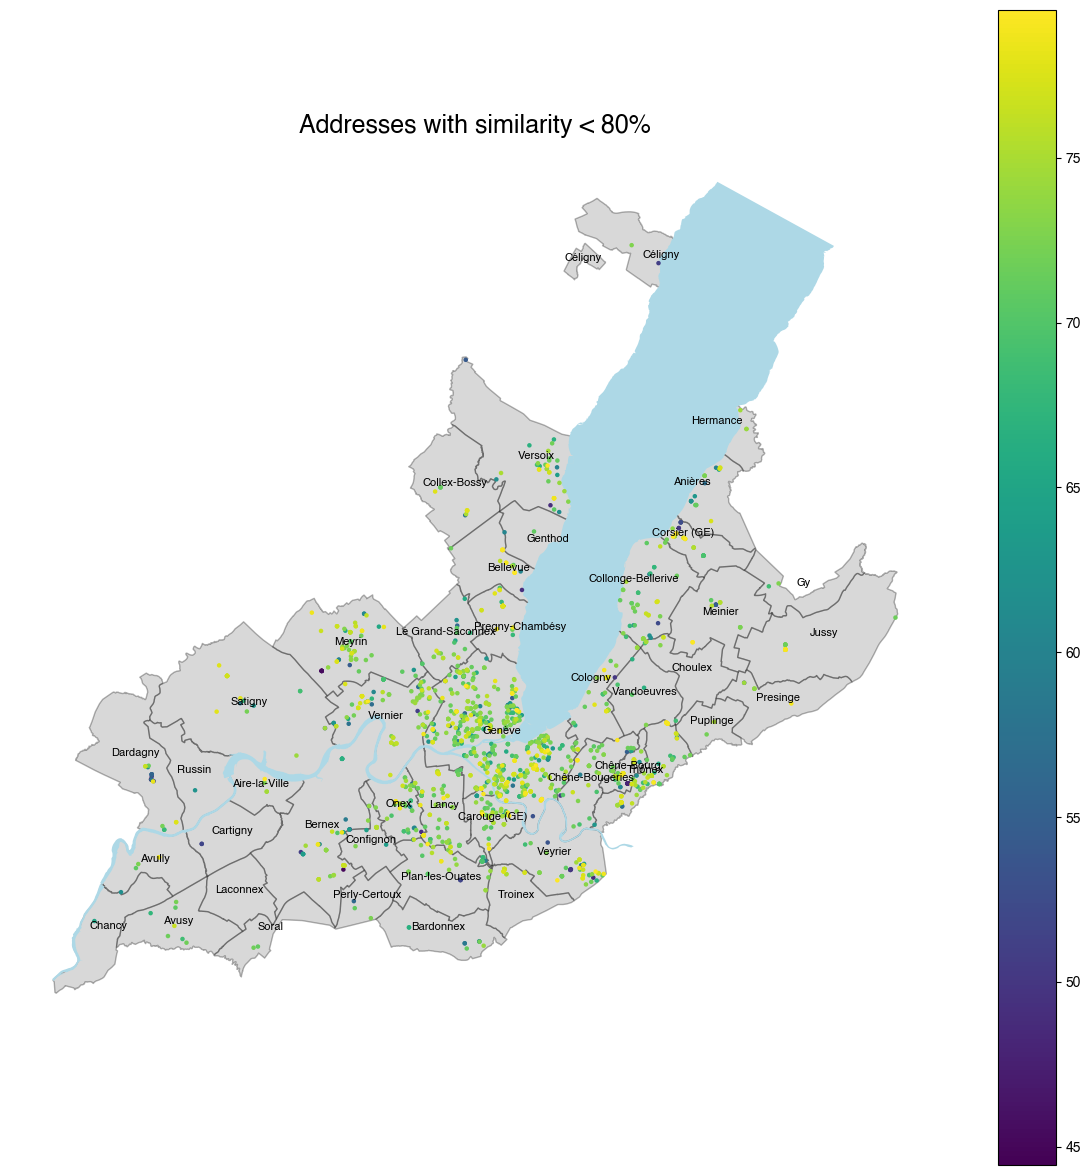

In [36]:
f, ax = plt.subplots(1, figsize=(15, 15))
communes.plot(ax = ax, label='Communes',alpha = 0.3,color=None,edgecolor='black',facecolor='grey')
communes.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center',size = 8),axis=1);
lake.plot(ax = ax, label='Lake',alpha = 1,color = 'lightblue')
gdf_geocoded[gdf_geocoded.comment == 'Low quality'].plot('similarity', markersize = 5,ax = ax, legend = True)
ax.set_title('Addresses with similarity < 80%',fontsize = 18)
ax.set_axis_off()
ax.set_facecolor('grey')

In [37]:
#Addresses that are complete but have a low similarity to RegBL
_ = gpd.sjoin(gdf_geocoded,communes[['NAME','geometry']],predicate = 'intersects')
_LQ = _[(_.comment == 'Low quality')]

In [38]:
_LQ = _LQ.rename(columns = {'E':'e','N':'n'})

In [39]:
# from esda.moran import Moran_Local

# li = Moran_Local(_LQ_600['similarity'], wq600, permutations=999)

In [40]:
# lisawq600 = pyspace.compute_lisa(_LQ_600,'similarity',wq600,999,0.05)

In [41]:
# pyspace.plotLISAMap_points(_LQ_600,'similarity','')

# Accessibility analyses

### Data Preparation

In [42]:
# Collect addresses from the centers
dic_centre = {'HUG - Maternité':[46.191174, 6.146240],
              'ImageRive':[46.202599, 6.150099],
              'CIO':[46.185712, 6.105039],
              'Clinique des Grangettes':[46.199840, 6.181743],
              'Clinique Générale Beaulieu':[46.188670, 6.161817],
              'MédImage SA':[46.196916, 6.154018],
              "Centre d'Imagerie Rive Gauche CIRG":[46.240752, 6.199488],
              'Hôpital de la Tour':[46.228690, 6.066374],
              "Institut d'Imagerie Médicale SA":[46.194231, 6.144169],
              "Centre d'Imagerie de la Servette":[46.212972, 6.125423],
              'Affidea CDRC':[46.186589, 6.143063],
              "Centre d'imagerie Rive Droite SA":[46.208147, 6.143412],
              'Imagerie Médicale Battikha':[46.210023, 6.143956],
              'Cabinet de radiologie Drs Berger & Teicher':[46.213017, 6.131947],
              'Imagerive LAC':[46.216705, 6.148251],
              'Cabinet de radiologie Dr Guinand-Mkinsi':[46.195798, 6.154703],
              'Clinique de la Colline':[46.191812, 6.149944],
              'Cabinet de radiologie Dr Arroja':[46.199595, 6.155487],
              'Centre Imagerie Versoix':[46.28096883497587, 6.165184209801708],
             "CIMG centre Imagerie médicale Genève":[46.216800901902246, 6.148267060384218]}

In [43]:
# with open(data_folder/'G.gpickle', 'wb') as f:
#     pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [44]:
df_centre =  pd.DataFrame.from_dict(dic_centre).T.reset_index()
df_centre.columns = ['center_name','lat','lon']

In [45]:
df_centre.loc[df_centre['center_name'].isin(["Cabinet de radiologie Dr Guinand-Mkinsi",
"Cabinet de radiologie Drs Berger & Teicher",
"Affidea CDRC",
"Clinique des Grangettes",
"Clinique Générale Beaulieu",
"Hôpital de la Tour",
"HUG - Maternité",
"Imagerie Médicale Battikha",
"ImageRive",
"Institut d'Imagerie Médicale SA",
"Rive Droite SA - Centre d'imagerie SA",
"Centre d'imagerie Rive Droite SA",
"Clinique de la Colline",                                    
"Cabinet de radiologie Dr Arroja"]),'year_start'] = 1999
df_centre.loc[df_centre['center_name'].isin(['MédImage SA']),'year_start'] = 2010
df_centre.loc[df_centre['center_name'].isin(['CIO']),'year_start'] = 2012
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie Rive Gauche CIRG"]),'year_start'] = 2013
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie de la Servette"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["CIMG centre Imagerie médicale Genève"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["Imagerive LAC"]),'year_start'] = 2019
df_centre.loc[df_centre['center_name'].isin(["Centre Imagerie Versoix"]),'year_start'] = 2020
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Drs Berger & Teicher']),'year_end'] = 2016
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Dr Guinand-Mkinsi']),'year_end'] = 2013

In [46]:
gdf_centre = pyspace.make_gdf(df_centre,4326,'lat','lon')
gdf_centre.to_file(data_folder/'BC_ScreeningCenters.geojson',driver = 'GeoJSON')

In [47]:
gdf_centre.index = gdf_centre.index.map(int)
gdf_centre['lon'] = gdf_centre.geometry.y
gdf_centre['lat'] = gdf_centre.geometry.x
gdf_centre['id'] = gdf_centre.index+1000000
gdf_centre['quantity'] = 1.0
gdf_centre['category'] = 'centre'
gdf_centre = gdf_centre.reset_index(drop=True)

In [48]:
gdf_centre = pyspace.make_gdf(gdf_centre, 4326, 'lon','lat')

### Import road network

In [49]:
# If network not previously saved
# G = ox.graph_from_place('Canton de Genève, Switzerland', network_type='all', simplify= True, clean_periphery = True)
# Otherwise
with open(data_folder/'G.gpickle', 'rb') as f:
    G = pickle.load(f)

In [50]:
# Project networks
Gp_4326 = ox.project_graph(G, to_crs = 4326)
Gp_2056 = ox.project_graph(G, to_crs = 2056)

### Calculation of access measures

In [51]:
import pandana as pdna

In [52]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges = gdf_edges.reset_index()

<Axes: >

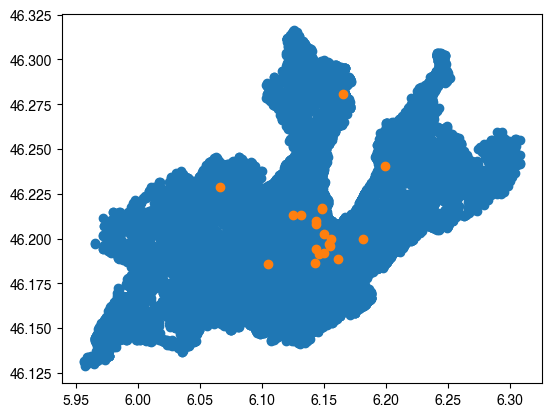

In [53]:
ax = gdf_nodes.plot()
gdf_centre.plot(ax = ax)

In [54]:
# Get nearest 2 POIs (screening center) at max 5km
net=pdna.Network(gdf_nodes["x"], gdf_nodes["y"], gdf_edges["u"], gdf_edges["v"],
                 gdf_edges[["length"]])
net.precompute(5000)
net.set_pois(category='centre', maxdist = 5000, maxitems=len(gdf_centre), x_col=gdf_centre['lon'], y_col=gdf_centre['lat'])
nearest_2 = net.nearest_pois(5000, "centre", num_pois=2)

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 58196
Setting CH edge vector of size 150081
Range graph removed 138926 edges of 300162
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [55]:
# Get POI density (screening centers) within 5km

x, y = gdf_centre.lon, gdf_centre.lat

gdf_centre["node_ids"] = net.get_node_ids(x, y)
net.set(gdf_centre["node_ids"], variable=gdf_centre['quantity'], name="centre")
density5000 = net.aggregate(5000, type="sum", decay="linear", name="centre")

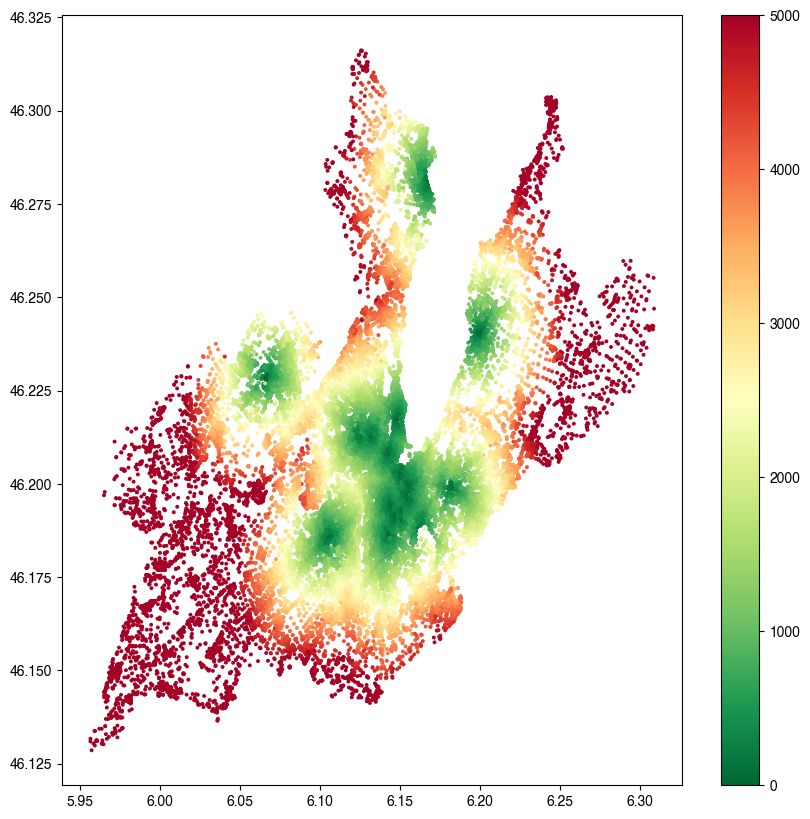

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

In [56]:
net.plot(nearest_2[1],
         fig_kwargs={'figsize': [10, 10]},
         plot_kwargs={'cmap': 'RdYlGn_r', 's': 8, 'edgecolor': 'none'})

In [1]:
nn_xy = ox.distance.nearest_nodes(Gp_2056, gdf_geocoded_ok.geometry.x, gdf_geocoded_ok.geometry.y)

NameError: name 'ox' is not defined

In [58]:
gdf_geocoded_ok['nearest_node'] = nn_xy
gdf_geocoded_ok['center_nearest'] = gdf_geocoded_ok['nearest_node'].map(nearest_2[1].to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
gdf_geocoded_ok['center_density'] = gdf_geocoded_ok['nearest_node'].map(density5000.to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
gdf_geocoded_ok_waccess = gdf_geocoded_ok.copy()

In [61]:
gdf_geocoded_ok_waccess = gpd.sjoin(gdf_geocoded_ok_waccess,cantons[cantons.NAME == 'Genève'][['geometry']], predicate = 'intersects')

<Axes: >

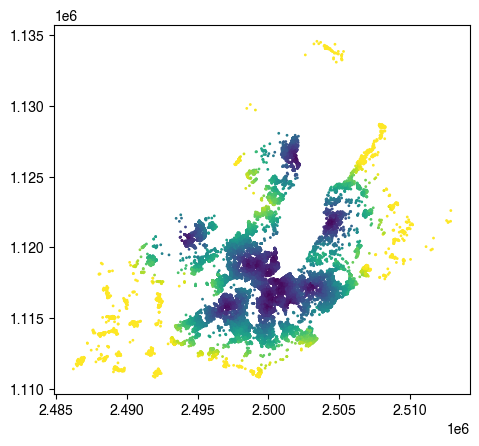

In [62]:
gdf_geocoded_ok_waccess[gdf_geocoded_ok_waccess.year_invit == 2019].plot('center_nearest', markersize = 1)

In [63]:
gdf_geocoded_ok_waccess = gdf_geocoded_ok_waccess.drop('index_right', axis = 1)

In [64]:
gdf_geocoded_ok_waccess.to_pickle(data_folder/'gdf_geom_nonull_gva_ok_waccess.pkl')

In [65]:
gdf_geocoded_ok_waccess.shape

(594361, 37)

## Spatial linkage to sociodemographic data (MicroGIS - neighborhood scale)

- We are gonna attach to each individual the variables from MicroGIS based on their place of residence

In [66]:
#Connect to PostGIS to fetch microgis data
query = """select nbid,"LOCALITY" locality,ciqmd,ptot,rad3prim, rad3sec,rad3tert,rprprot,rprcath,rprochr,rprjew,rprmusl,rproth,rprnorel,rpnch,rphhpriv,rpfnone,rpfobl,rpfgen,rpfprof,rpfmat,rpfprsf,rpfprss ,rpfbac,rpfmas,rpfphd,rad,radf,radunef,radslib,dmdrent,b.geom geometry from data_raw.microgis_data_gva a, data_raw.microgis_geo_gva b where a.nbid = b."NBID" and b.geom is not null ;"""
microgis_data = gpd.GeoDataFrame.from_postgis(query, con = engine, geom_col='geometry')

In [67]:
#Make spatial join to assign area-based variables to the GIRACS individuals
gdf_geom_ok_waccess_wmicrogis = gpd.sjoin(gdf_geocoded_ok_waccess,microgis_data[['nbid','geometry']], how = 'left', predicate = 'intersects').drop('index_right',axis = 1)

In [70]:
gdf_geom_ok_waccess_wmicrogis = gdf_geom_ok_waccess_wmicrogis[~(gdf_geom_ok_waccess_wmicrogis.uuid.duplicated())]

In [75]:
import math
def minDistCalc(points,polygons):
    """Checks the closest MicroGIS neighborhood for all the points that don't interesect. 
    Iterates over the points, polygons and multipolygons and return the minDist"""
    for i,line in points.iterrows():
        if math.isnan(line.nbid) == True:
            mindistance = 9999
            for index,row in polygons.iterrows():
                if row.geometry.geom_type == 'Polygon':
                    dist = row.geometry.exterior.distance(line.geometry)
                    if dist<mindistance:
                        mindistance,nbid,locality = dist, row.nbid,row.locality
                else:
                    for poly in row['geometry'].geoms:
                        dist = poly.exterior.distance(line.geometry)
                        if dist<mindistance:
                            mindistance,nbid,locality = dist, row.nbid,row.locality
            print(nbid,locality)
            points.at[i,'nbid'] = nbid #Note: .at returns an error (BlockManager blabla) when there are column name duplicates
minDistCalc(gdf_geom_ok_waccess_wmicrogis, microgis_data)

3890 Genève
5587 Anières
5587 Anières
5587 Anières
5587 Anières
4032 Genève
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5587 Anières
5151 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
5164 Carouge GE
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4629 Onex
4458 Genève
4554 Petit-Lancy
5087 Chêne-Bourg
5087 Chêne-Bourg
4554 Petit-Lancy
5087 Chêne-Bourg
5087 Chêne-Bourg
5087 Chêne-Bourg
5087 Chêne-Bourg
4554 Petit-Lancy
5087 Chêne-Bourg
5087 Chêne-Bourg
4629 Onex
4629 Onex
4629 Onex
6475 Genthod
4629 Onex
4629 Onex
5147 Carouge GE
4629 Onex
4629 Onex
4320 Genève
4320 Genève
4320 Genève
4320 Genève
4320 Genève
4320 Genève
4320 Genève
4320 Genèv

5561 Collonge-Bellerive
4952 Vésenaz
4966 Vésenaz
5485 Puplinge
4966 Vésenaz
6267 Dardagny
5457 Vessy
4611 Petit-Lancy
112798 Jussy
5607 Hermance
112798 Jussy
3890 Genève
102976 Genève
103167 Vandoeuvres
4970 Vésenaz
5062 Chêne-Bourg
5258 Les Acacias
4970 Vésenaz
3890 Genève
98215 Thônex
4970 Vésenaz
5481 Collex
4067 Genève
5378 Confignon
4970 Vésenaz
4816 Le Grand-Saconnex
4131 Genève
4528 Grand-Lancy
4131 Genève
4131 Genève
5164 Carouge GE
4080 Genève
5301 Plan-les-Ouates
165578 Thônex
4966 Vésenaz
4504 Grand-Lancy
4970 Vésenaz
6368 Versoix
5674 Veyrier
6320 Versoix
4952 Vésenaz
3890 Genève
5013 Chêne-Bougeries
4829 Le Grand-Saconnex
4131 Genève
6304 Laconnex
4131 Genève
6267 Dardagny
4484 Genève
5457 Vessy
4131 Genève
98237 Satigny
112799 La Croix-de-Rozon
112796 Presinge
103016 Vernier
103281 Soral
102976 Genève
4897 Aïre
4381 Genève
5571 Corsier GE
4970 Vésenaz
4080 Genève
5164 Carouge GE
98250 Anières
5692 La Croix-de-Rozon
6423 Chambésy
3890 Genève
3890 Genève
5060 Chêne-Bourg
5

3890 Genève
6435 Bellevue
112798 Jussy
6267 Dardagny
102976 Genève
4080 Genève
4970 Vésenaz
3890 Genève
4067 Genève
112798 Jussy
6368 Versoix
4032 Genève
5389 Bernex
4829 Le Grand-Saconnex
3890 Genève
4067 Genève
4615 Petit-Lancy
102976 Genève
4968 Vésenaz
4080 Genève
4080 Genève
103040 Meyrin
4067 Genève
6435 Bellevue
4966 Vésenaz
103040 Meyrin
4968 Vésenaz
6435 Bellevue
5087 Chêne-Bourg
4829 Le Grand-Saconnex
6304 Laconnex


In [76]:
#Make spatial join to assign area-based variables to the GIRACS individuals
gdf_geom_ok_waccess_wmicrogis = pd.merge(gdf_geom_ok_waccess_wmicrogis, microgis_data.drop('geometry',axis = 1), how = 'left',on = 'nbid')

In [77]:
gdf_geom_ok_waccess_wmicrogis = gdf_geom_ok_waccess_wmicrogis.reset_index(drop = True)

In [78]:
gdf_geom_ok_waccess_wmicrogis.to_pickle(data_folder/'gdf_geom_nonull_gva_ok_waccess_wmicrogis.pkl')

In [79]:
gdf_geom_ok_waccess_wmicrogis = pd.read_pickle(data_folder/'gdf_geom_nonull_gva_ok_waccess_wmicrogis.pkl')

In [80]:
df_giracs = gdf_geom_ok_waccess_wmicrogis.drop(['adresse1','adresse2','adresse3','country','locality','street','adr_num'],axis = 1)

In [81]:
df_giracs = df_giracs.rename(columns = {'E':'e','N':'n'})

In [82]:
# df_giracs = pd.merge(df_geocoded,_mergewdf,on = 'full_address').drop_duplicates()

In [83]:
df_giracs = pyspace.add_random_noise(df_giracs)

## Define new features

In [85]:
#Transform variable to binary
df_giracs.loc[df_giracs.medecin == 'oui','medecin_code'] =1
df_giracs.loc[df_giracs.medecin == 'non','medecin_code'] =0
df_giracs.loc[df_giracs.medecin == 'je ne sais pas','medecin_code'] = np.nan

In [86]:
#Transform variable to binary
df_giracs.loc[df_giracs.autremedecin == 'oui','autremedecin_code'] =1
df_giracs.loc[df_giracs.autremedecin == 'non','autremedecin_code'] =0
df_giracs.loc[df_giracs.autremedecin == 'je ne sais pas','autremedecin_code'] = np.nan

In [87]:
#Transform variable to binary
df_giracs.loc[df_giracs.mammoanterieure == 'oui','mammoanterieure_code'] =1
df_giracs.loc[df_giracs.mammoanterieure == 'non','mammoanterieure_code'] =0
df_giracs.loc[df_giracs.mammoanterieure == 'je ne sais pas','mammoanterieure_code'] = np.nan

In [88]:
#Transform variable to binary
df_giracs.loc[df_giracs.atf == 'oui','atf_code'] =1
df_giracs.loc[df_giracs.atf == 'non','atf_code'] =0
df_giracs.loc[df_giracs.atf == 'je ne sais pas','atf_code'] = np.nan

In [89]:
#Transform variable to binary
rappel = 1* (df_giracs.daterappel.isnull()==False)
df_giracs = df_giracs.assign(rappel = rappel)

In [90]:
#Transform variable to binary
df_giracs= df_giracs.assign(mammo = 1* (df_giracs.datemammographie.isnull()==False))

In [91]:
#Create variables from date columns
df_giracs['dateinvitation'] = pd.to_datetime(df_giracs['dateinvitation'])
df_giracs['daterappel'] = pd.to_datetime(df_giracs['daterappel'])
df_giracs['datemammographie'] = pd.to_datetime(df_giracs['datemammographie'])

In [92]:
#Create variables from date columns
df_giracs['t_invit_rappel'] = df_giracs['daterappel'] - df_giracs['dateinvitation']
df_giracs['t_invit_rappel']=df_giracs['t_invit_rappel']/np.timedelta64(1,'D')

df_giracs['t_invit_mammo'] = df_giracs['datemammographie'] - df_giracs['dateinvitation']
df_giracs['t_invit_mammo']=df_giracs['t_invit_mammo']/np.timedelta64(1,'D')

In [93]:
#Create variables from date columns
df_giracs['year_invit'] = df_giracs.dateinvitation.dt.year
df_giracs['month_invit'] = df_giracs.dateinvitation.dt.month
df_giracs['day_invit'] = df_giracs.dateinvitation.dt.day
df_giracs['weekday_invit'] = df_giracs.dateinvitation.dt.day_name()

df_giracs['year_rappel'] = df_giracs.daterappel.dt.year
df_giracs['month_rappel'] = df_giracs.daterappel.dt.month
df_giracs['day_rappel'] = df_giracs.daterappel.dt.day
df_giracs['weekday_rappel'] = df_giracs.daterappel.dt.day_name()

df_giracs['year_mammo'] = df_giracs.datemammographie.dt.year
df_giracs['month_mammo'] = df_giracs.datemammographie.dt.month
df_giracs['day_mammo'] = df_giracs.datemammographie.dt.day
df_giracs['weekday_mammo'] = df_giracs.datemammographie.dt.day_name()

In [94]:
df_giracs = pyspace.make_gdf(df_giracs,2056,'e','n')

In [95]:
df_giracs.shape

(594361, 80)

## Create working dataset

In [96]:
df_giracs['longitude'] = df_giracs.to_crs(epsg=4326).geometry.x
df_giracs['latitude'] = df_giracs.to_crs(epsg=4326).geometry.y

In [97]:
df_giracs['city'] = df_giracs['city'].astype(str)

df_giracs.loc[df_giracs.city == 'Athenaz (Avusy)','city'] = 'Avusy'
df_giracs.loc[df_giracs.city == 'Chambésy','city'] ='Pregny-Chambésy'
df_giracs.loc[df_giracs.city.str.contains('Lancy'),'city'] = 'Lancy'
df_giracs.loc[df_giracs.city == 'Collex','city'] = 'Collex-Bossy'
df_giracs.loc[df_giracs.city == 'La Croix-de-Rozon','city'] = 'Bardonnex'
df_giracs.loc[df_giracs.city == 'Perly','city'] = 'Perly-Certoux'

In [99]:
df_giracs.to_csv(data_folder/'giracs_input.csv',index = False)

In [100]:
df_giracs = pd.read_csv(data_folder/'giracs_input.csv')

/var/folders/vs/k61m7qc90ds735nc0468d1x80000gn/T/ipykernel_94975/93408473.py:1: DtypeWarning:

Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.



In [101]:
df_giracs.shape

(594361, 82)

# Data analysis

## Exploratory phasis

In [102]:
#Get number of people in the dataframe
print('Number of people in the dataset: ',len(df_giracs.numerodossier.unique()))
patients = df_giracs.groupby('numerodossier').sum()
print('Number of people having done a breast cancer screening (mammography): ',len(patients[patients.mammo > 0]))

Number of people in the dataset:  136134
Number of people having done a breast cancer screening (mammography):  56482


In [103]:
print('Number of people without a conclusion (NULL) while having done a screening : ',len(df_giracs[(df_giracs.conclusion.isnull()==True)&(df_giracs.day_mammo.isnull()==False)]))

Number of people without a conclusion (NULL) while having done a screening :  22843


Text(0.5, 0, 'Data GIRACS')

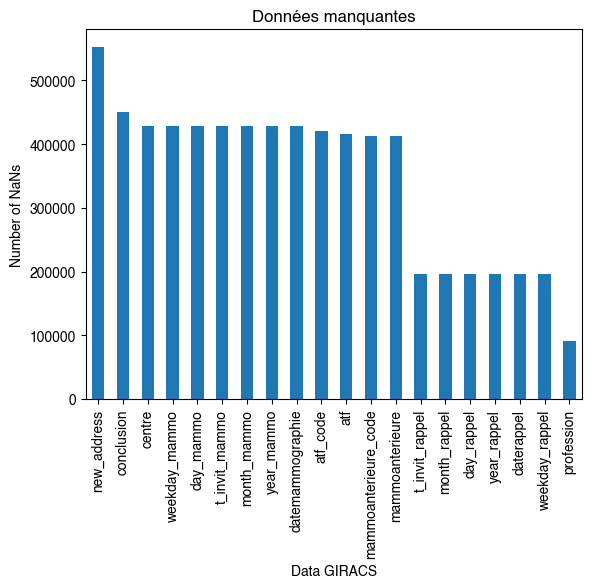

In [104]:
#Plot the 20 variables having the most NAs
isna_ = df_giracs.isnull().sum().sort_values(ascending=False)
plt.plot()
plt.title('Données manquantes')
plt_1=isna_[:20].plot(kind='bar')
plt.ylabel('Number of NaNs')
plt.xlabel('Data GIRACS')

We notice that we have a lot of missing values depending on the variable mammo 0 or 1. It makes total sense that if a woman doesn't do the mammo, we lack all the information down the way.

Text(0.5, 0, 'Breast cancer screening center')

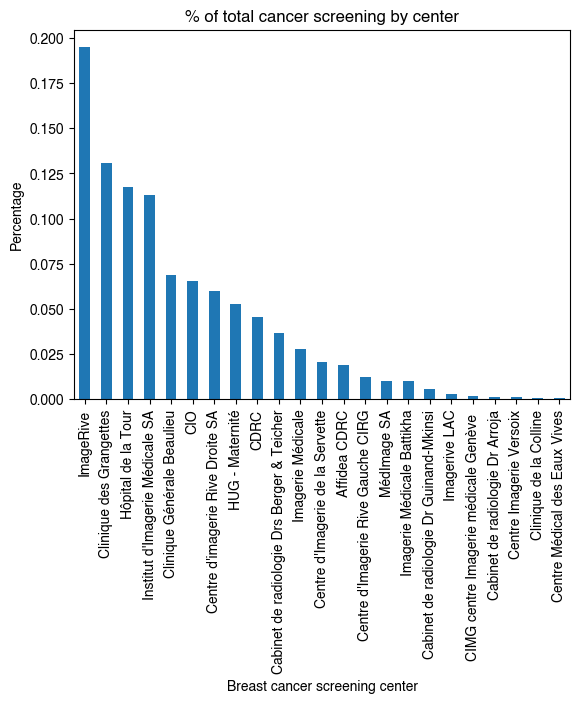

In [105]:
plt.plot()
plt.title('% of total cancer screening by center')
df_giracs.centre.value_counts(normalize=True).plot.bar()
plt.ylabel('Percentage')
plt.xlabel('Breast cancer screening center')

We see that the ImageRive is far ahead of any other center, gathering more than 20% of all screenings. We could test:

- Is this correlated to the total population living at less than 1,2,5k ?
    - Probably not that much, I highly doubt that Imagerive LAC has very little population around or that Clinique de la Colline has zero. 
    - Questions for Beatrice : Why would that be? Was that a known fact? Close to where people work? Incentives to go there (flyers, reputation of quality, recommendation from physician,convenience of getting an appointment,...)? 
    
 ### TO DO:
- Collect the addresses of these centers for accessibility analyses!

In [ ]:
age_group = df_giracs.groupby('groupeage').sum().mul(100)/df_giracs.groupby('groupeage').count()
age_group['Age group'] = age_group.index

In [ ]:
age_group_mu = df_giracs.groupby('groupeage').mean()
age_group_mu['Age group'] = age_group.index

In [ ]:
wkday_mammo = df_giracs.groupby('weekday_mammo').count()
wkday_mammo['Jour Mammographie'] = wkday_mammo.index

In [ ]:
age_group.set_index("Age group").atf_code.plot.barh()

In [ ]:
alt.Chart(age_group).mark_bar().encode(
  x='t_invit_mammo:Q',
  y='Age group:N',
  color='Age group:N'
)

In [ ]:
alt.Chart(age_group).mark_bar().encode(
  x='medecin:Q',
  y='Age group:N',
  color='Age group:N'
)

In [ ]:
alt.Chart(wkday_mammo).mark_bar().encode(
  x='atf_code:Q',
  y='Jour Mammographie:N',
  color='Jour Mammographie:N'
)

In [ ]:
isna_ = df_giracs[['mammo','year_invit','month_invit','day_invit','rappel','medecin','mammoanterieure','atf','groupeage','rprprot','rpnch','rprmusl','rphhpriv','rpfbac','rpfmas','rad','radf','radunef','dmdrent']].isnull().sum().sort_values(ascending=False)
plt.plot()
plt.title('Données manquantes')
plt_1=isna_[:20].plot(kind='bar')
plt.ylabel('Number of NaNs')
plt.xlabel('Data GIRACS')

# Spatial analyses

### First scenario

Here we consider the simple case where the participation to a screening doesn't depend on the person's history of participation.

$$P(screening|historic) = P(screening)$$ 

We will compute a MGWR analysis considering each screening invitation as a different person. We will use a Binomial logistic GWR for boolean data.

In [ ]:
from spglm.family import Binomial

In [ ]:
test_set = df_giracs.sample(3000)

In [ ]:
first_invit = df_giracs[(df_giracs.numeroinvitation ==1)&(df_giracs.etatcivil.isnull()==False)]

In [ ]:
df_giracs.to_csv('giracs_dataset.csv',index = False)

In [ ]:
c = df_giracs.groupby(['etatcivil','mammo'])['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('mammo').fillna(0)
yerr = ((test[1]*(1-test[1]))/(c.unstack('mammo')[0]+c.unstack('mammo')[1]))**(0.5)
f,ax = plt.subplots(figsize = (10,10))
test[1].plot(kind = 'bar',yerr = yerr,color = ['lightblue'],ax = ax).legend(bbox_to_anchor=(1,1))
ax.set_title('Pourcentage de participation au screening cancer du sein par etat civil')
plt.savefig('participation_etatcivil.png',bbox_inches='tight', transparent=True,dpi = 400)

In [ ]:
group_age = pd.get_dummies(test_set['groupeage'])
#Concat new columns to original dataframe 
test_set = pd.concat([test_set, group_age], axis=1)

In [ ]:
isna_ = test_set.isnull().sum().sort_values(ascending=False)
plt.plot()
plt.title('Données manquantes')
plt_1=isna_[:20].plot(kind='bar')
plt.ylabel('Number of NaNs')
plt.xlabel('Data GIRACS')

In [ ]:
def model_prep(df,y,X):
    """Prepare data for subsequent GWR/MGWR"""
    g_y = df[y].values.reshape(-1, 1)
    g_X = df[X].values
    u = df['x']
    v = df['y']
    g_coords = list(zip(u,v))
    g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
    g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
    return g_y, g_X, g_coords

In [ ]:
def plot_gwr_mgwr(df,X,gwr_filtered_t,mgwr_filtered_t,result_dir):
    kwargs1 = {'edgecolor': 'lightgrey', 'markersize': 175}
    kwargs2 = {'facecolor': 'lightgrey', 'markersize': 175}
    print('*'*30,'Start of plotting step','*'*30)
    for i,var in enumerate(X):
        var_gwr,var_mgwr = 'gwr_'+ var,'mgwr_'+ var
        compare_surfaces(df, var_gwr, var_mgwr,
        gwr_filtered_t[:,i+1], gwr_bw,
        mgwr_filtered_t[:, i+1], mgwr_bw[i+1],
        var, kwargs1, kwargs2, savefig = result_dir/var)
    print('*'*30,'End 😁','*'*30)

In [ ]:
def gaussian_gwr_mgwr(df,df_name,y,X,gwr_ofile,mgwr_ofile):
    mydir = Path(os.getcwd())
    print ("The current working directory is %s" % mydir)
    result_dir = mydir / 'Results' / df_name
    if os.path.exists(result_dir):
        pass
    else:
        os.mkdir(result_dir)
    g_y,g_X,g_coords = model_prep(df,y,X)
    #Initiate pp
    n_proc = 4
    pool = mp.Pool(n_proc)
    #Start GWR
    print('*'*30,'Start of GWR modelling','*'*30)
    #Calibrate GWR using standardized data
    gwr_selector = Sel_BW(g_coords, g_y, g_X)
    gwr_bw = gwr_selector.search(verbose = True,pool = pool)
    with open(result_dir/gwr_ofile,'w') as file_gwr:
        print('GWR Global Bandwidth = ',gwr_bw)
        print('GWR Global Bandwidth = ',gwr_bw,file = file_gwr)
        gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
        gwr_results = gwr_model.fit(pool = pool)
        with redirect_stdout(file_gwr):
            gwr_results.summary()
    #Add GWR parameters to GeoDataframe
    df['gwr_intercept'] = gwr_results.params[:, 0]
    for i,var in enumerate(X):
        var_str = 'gwr_'+var
        df[var_str] = gwr_results.params[:, i+1]
    #Obtain t-vals filtered based on multiple testing correction
    gwr_filtered_t = gwr_results.filter_tvals()
    print('*'*30,'Start of MGWR modelling','*'*30)
    #Calibrate MGWR model
    mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi = True)
    mgwr_bw = mgwr_selector.search(pool=pool,verbose = True)
    with open(result_dir / mgwr_ofile,'w') as file_mgwr:
        print('GWR Global Bandwidth = ',mgwr_bw)
        print('GWR Global Bandwidth = ',mgwr_bw,file = file_mgwr)
        mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit(pool = pool)
        with redirect_stdout(file_mgwr):
            mgwr_results.summary()
    pool.close() # Close the pool when you finish
    pool.join()
    df['mgwr_intercept'] = mgwr_results.params[:, 0]
    for i,var in enumerate(X):
        var_str = 'mgwr_'+var
        df[var_str] = mgwr_results.params[:, i+1]
    #Obtain t-vals filtered based on multiple testing correction
    mgwr_filtered_t = mgwr_results.filter_tvals()
    #Quality control measures
    LCC, VIF, CN, VDP = gwr_results.local_collinearity()
    mgwr_lc = mgwr_results.local_collinearity()
    df['gwr_cn'] = CN
    df['mgwr_cn'] = mgwr_lc[0]
    #Create plots
    #1 Compare Surfaces
    plot_gwr_mgwr(df,X,gwr_filtered_t,mgwr_filtered_t,result_dir)
    #2 Condition Number
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
    ax0 = axes[0]
    ax0.set_title('GWR Condition Number', fontsize = 10)
    ax1 = axes[1]
    ax1.set_title('MGWR Condition Number', fontsize = 10)
    cmap = mpl.cm.RdYlBu
    vmin = np.min([df['gwr_cn'].min(), df['mgwr_cn'].min()])
    vmax = np.max([df['gwr_cn'].max(), df['mgwr_cn'].max()])
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = vmin,vmax = vmax))
    df.plot('gwr_cn', cmap = sm.cmap, ax = ax0, vmin = vmin, vmax = vmax, **{'edgecolor': 'lightgrey', 'alpha': .95, 'linewidth': .75})
    df.plot('mgwr_cn', cmap = sm.cmap, ax = ax1, vmin = vmin, vmax = vmax, **{'edgecolor': 'lightgrey', 'alpha': .95, 'linewidth': .75})
    fig.tight_layout()
    fig.subplots_adjust(right = 0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax = cax)
    cbar.ax.tick_params(labelsize = 10)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.savefig(results_dir/'compare_collin')
    #3 LCC
    names = []
    for pair in itertools.product(X, repeat=2):
        if pair[0] != pair[1]:
            names.append(' vs '.join(pair))
    for col in range(len(names)):
        fig, ax = plt.subplots(figsize = (4, 4))
        df['lcc'] = LCC[:, col]
        df.plot('lcc', ax = ax, legend = True)
        title = 'LCC: ' + names[col]
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(results_dir/title)
    names = X
    for col in range(len(X)):
        fig, ax = plt.subplots(figsize = (12, 4))
        df['vif'] = VIF[:, col]
        df.plot('vif', ax = ax, legend = True)
        title  = 'VIF: ' + names[col]
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(results_dir/title)
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    df['cn'] = CN
    df.plot('cn', legend = True, ax = ax)
    ax.set_title('Condition Number')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    names.append('Intercept')
    fig, ax = plt.subplots(1, 4, figsize = (16, 4))
    for col in range(len(names)):
        df['vdp'] = VDP[:, col]
        df.plot('vdp', ax = ax[col], legend = True)
        ax[col].set_title('VDP: ' + names[col])
        ax[col].get_xaxis().set_visible(False)
        ax[col].get_yaxis().set_visible(False)

In [ ]:
# gaussian_gwr_mgwr(df4_oh,'df4_oh','log_oh',['sex', 'age','Married','University','ciqmd','Current','bmi','bar_density','bar_nearest','bar_5nearest'],'df4_oh_gwr.csv','df4_oh_mgwr.csv')

In [ ]:
############
g_y = test_set['mammo'].values.reshape(-1, 1)
g_X = test_set[['year_invit','month_invit','day_invit','rappel','medecin','mammoanterieure','atf','rprprot','rpnch','rprmusl','rphhpriv','rpfbac','rpfmas','rad','radf','radunef','dmdrent']].values


u = test_set['e']
v = test_set['n']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [ ]:
X = ['year_invit','month_invit','day_invit','rappel','medecin','mammoanterieure','atf','rprprot','rpnch','rprmusl','rphhpriv','rpfbac','rpfmas','rad','radf','radunef','dmdrent']

In [ ]:
#This might be needed to turn off the OpenMP multi-threading
%env OMP_NUM_THREADS = 1

In [ ]:
n_proc = 4 #4 cores
pool = mp.Pool(n_proc) 

In [ ]:
%%time
#Calibrate GWR using standardized~data
gwr_selector = Sel_BW(g_coords, g_y, g_X,family = Binomial())
gwr_bw = gwr_selector.search(pool=pool)
print(gwr_bw)
gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_results = gwr_model.fit(pool = pool)

In [ ]:
#Prepare GWR results for~mapping
#Add GWR parameters to GeoDataframe
test_set['gwr_intercept'] = gwr_results.params[:, 0]
test_set['gwr_year_invit'] = gwr_results.params[:, 1]
test_set['gwr_month_invit'] = gwr_results.params[:, 2]
test_set['gwr_day_invit'] = gwr_results.params[:, 3]
test_set['gwr_rappel'] = gwr_results.params[:, 4]
test_set['gwr_medecin'] = gwr_results.params[:, 5]
test_set['gwr_mammoanterieure'] = gwr_results.params[:, 6]
test_set['gwr_atf'] = gwr_results.params[:, 7]
test_set['gwr_rprprot'] = gwr_results.params[:,8] 
test_set['gwr_rpnch'] = gwr_results.params[:, 9]
test_set['gwr_rprmusl'] = gwr_results.params[:, 10]
test_set['gwr_rphhpriv'] = gwr_results.params[:, 11]
test_set['gwr_rpfbac'] = gwr_results.params[:, 12]
test_set['gwr_rpfmas'] = gwr_results.params[:, 13]
test_set['gwr_rad'] = gwr_results.params[:,14] 
test_set['gwr_radf'] = gwr_results.params[:, 15]
test_set['gwr_radunef'] = gwr_results.params[:,16] 
test_set['gwr_dmdrent'] = gwr_results.params[:, 17]

In [ ]:
#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [ ]:
%%time
#Calibrate MGWR~model
mgwr_selector = Sel_BW(g_coords, g_y, g_X,family = Binomial(), multi = True)
mgwr_bw = mgwr_selector.search(pool =pool)
print(mgwr_bw)

In [ ]:
%%time 
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit(pool = pool)

In [ ]:
mgwr_results.summary()

In [ ]:
test_set['mgwr_intercept'] = mgwr_results.params[:, 0]
test_set['mgwr_year_invit'] = mgwr_results.params[:, 1]
test_set['mgwr_month_invit'] = mgwr_results.params[:, 2]
test_set['mgwr_day_invit'] = mgwr_results.params[:, 3]
test_set['mgwr_rappel'] = mgwr_results.params[:, 4]
test_set['mgwr_medecin'] = mgwr_results.params[:, 5]
test_set['mgwr_mammoanterieure'] = mgwr_results.params[:, 6]
test_set['mgwr_atf'] = mgwr_results.params[:, 7]
test_set['mgwr_rprprot'] = mgwr_results.params[:,8] 
test_set['mgwr_rpnch'] = mgwr_results.params[:, 9]
test_set['mgwr_rprmusl'] = mgwr_results.params[:, 10]
test_set['mgwr_rphhpriv'] = mgwr_results.params[:, 11]
test_set['mgwr_rpfbac'] = mgwr_results.params[:, 12]
test_set['mgwr_rpfmas'] = mgwr_results.params[:, 13]
test_set['mgwr_rad'] = mgwr_results.params[:,14] 
test_set['mgwr_radf'] = mgwr_results.params[:, 15]
test_set['mgwr_radunef'] = mgwr_results.params[:,16] 
test_set['mgwr_dmdrent'] = mgwr_results.params[:, 17]

In [ ]:
#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

In [ ]:
kwargs1 = {'edgecolor': 'lightgrey', 'markersize': 175}
kwargs2 = {'facecolor': 'lightgrey', 'markersize': 175}

In [ ]:
mydir/'Results'

In [ ]:
for i, var in enumerate(X):
    var_gwr,var_mgwr = 'gwr_'+var,'mgwr_'+var
    compare_surfaces(test_set, var_gwr, var_mgwr,
    gwr_filtered_t[:, i+1], gwr_bw,
    mgwr_filtered_t[:, i+1], mgwr_bw[i+1],
    var, kwargs1, kwargs2, savefig = mydir/'Results'/var)

In [ ]:
compare_surfaces(test_set, 'gwr_intercept', 'mgwr_intercept',
gwr_filtered_t[:, 0], gwr_bw,
mgwr_filtered_t[:, 0], mgwr_bw[0],
'Intercept', kwargs1, kwargs2, savefig = 'b1')

In [ ]:
compare_surfaces(test_set, 'gwr_year_invit', 'mgwr_year_invit', gwr_filtered_t[:, 1],
gwr_bw, mgwr_filtered_t[:, 1], mgwr_bw[1],
'Year of invitation', kwargs1, kwargs2, savefig = 'b2')

In [ ]:
compare_surfaces(test_set, 'gwr_medecin', 'mgwr_medecin', gwr_filtered_t[:, 5],
gwr_bw, mgwr_filtered_t[:, 5], mgwr_bw[5],
'Medecin', kwargs1, kwargs2, savefig = 'b2')

In [ ]:
compare_surfaces(test_set, 'gwr_mammoanterieure', 'mgwr_mammoanterieure', gwr_filtered_t[:, 6],
gwr_bw, mgwr_filtered_t[:, 6], mgwr_bw[6],
'Mammographie antérieure', kwargs1, kwargs2, savefig = 'b2')

In [ ]:
compare_surfaces(test_set, 'gwr_atf', 'mgwr_atf', gwr_filtered_t[:, 7],
gwr_bw, mgwr_filtered_t[:, 7], mgwr_bw[7],
'Antécédants familiaux', kwargs1, kwargs2, savefig = 'b2')